In [85]:
import pandas as pd


In [86]:
pip install pandas

# ML

In [87]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [88]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [90]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

df_final_clean = pd.read_excel("df_final_clean.xlsx")
df_final_clean_encoded = df_final_clean.copy()

# ✅ 3. แปลง categorical เป็นตัวเลข (ถ้ามี)
for col in df_final_clean_encoded.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df_final_clean_encoded[col] = le.fit_transform(df_final_clean_encoded[col]).astype(int)

df_final_clean_encoded = df_final_clean_encoded.drop(columns=['date'])
df_final_clean_encoded

,cases,temp_15d_avg,rain_15d_avg,humid_15d_avg,อายุ(ปี),เพศ,อาชีพ,ตำบล,อำเภอ,เดือน,ปี,ไตรมาส,ฤดูกาล
0,1,22.745000,0.000000,74.794444,34.0,0,0,8,1,2,2017,1,2
1,1,27.170000,2.386667,74.827333,13.0,0,10,60,8,4,2017,2,1
2,1,27.786667,2.520000,73.410667,51.0,1,0,60,8,5,2017,2,1
3,1,27.970000,4.253333,73.302667,14.0,1,10,60,8,5,2017,2,1
4,2,28.501333,4.233333,73.984667,58.0,0,9,60,8,5,2017,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2,22.858571,2.071429,82.036429,20.5,1,6,3,2,12,2024,4,2
1046,2,22.716667,1.933333,81.784000,56.0,0,7,31,2,12,2024,4,2
1047,1,21.687333,1.933333,82.676000,11.0,1,10,15,2,12,2024,4,2
1048,1,21.304667,1.933333,82.992667,41.0,1,7,35,6,12,2024,4,2


In [91]:
df_final_clean_encoded.corr()['cases']

cases            1.000000
temp_15d_avg     0.100030
rain_15d_avg     0.094145
humid_15d_avg    0.018460
อายุ(ปี)        -0.034136
เพศ              0.007874
อาชีพ            0.088724
ตำบล             0.051749
อำเภอ            0.042857
เดือน           -0.005328
ปี               0.229528
ไตรมาส           0.013666
ฤดูกาล          -0.147233
Name: cases, dtype: float64

In [95]:
pip install seaborn



  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


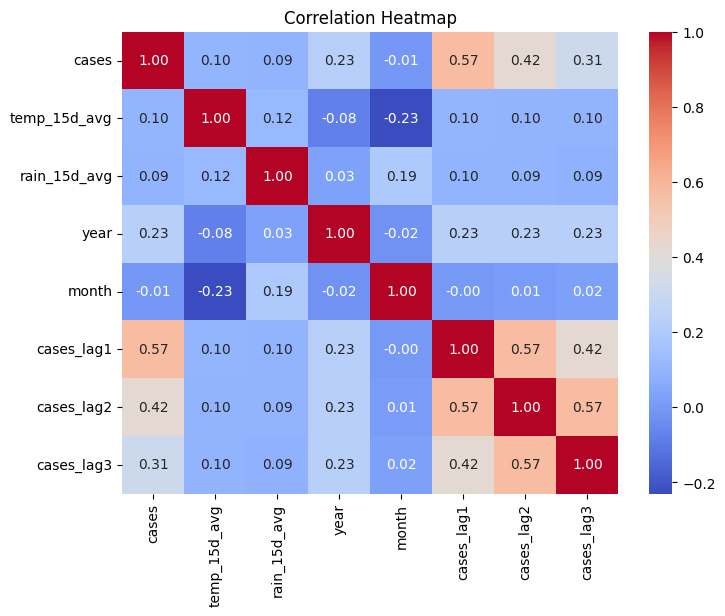

📊 Model Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393
✅ Model trained & saved with correlation check + categorical encoding + lag features


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------- Load Data -------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ------------------- Generate Lag Features -------------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ------------------- Correlation (EDA) -------------------
corr = df[["cases", "temp_15d_avg", "rain_15d_avg", 
           "year", "month", "cases_lag1", "cases_lag2", "cases_lag3"]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# ------------------- Features -------------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ------------------- One-hot encode categorical -------------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ------------------- Train/Test split -------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# ------------------- Train XGBoost -------------------
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)

# ------------------- Evaluate -------------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# ------------------- Save model + features + encoder -------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("✅ Model trained & saved with correlation check + categorical encoding + lag features")


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import joblib
import numpy as np

# ---------------- Load Data ----------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ---------------- Generate Lag Features ----------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ---------------- Features ----------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ---------------- One-hot Encode ----------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# ======================= Train Models =======================
# 1. XGBoost
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 2. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 3. Deep Learning (MLPRegressor)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32), activation="relu",
    solver="adam", max_iter=500, random_state=42
)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

# ======================= Evaluate =======================
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Performance:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
    return rmse, mae, r2

eval_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb)
eval_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
eval_mlp = evaluate_model("Deep Learning (MLP)", y_test, y_pred_mlp)

# ======================= Save Models =======================
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(rf_model, "rf_regressor.pkl")
joblib.dump(mlp_model, "mlp_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("\n✅ All models trained & saved successfully!")



📊 XGBoost Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393

📊 Random Forest Performance:
RMSE: 2.52, MAE: 1.70, R²: 0.402

📊 Deep Learning (MLP) Performance:
RMSE: 2.70, MAE: 1.67, R²: 0.313

✅ All models trained & saved successfully!


In [4]:
X_final

,temp_15d_avg,rain_15d_avg,year,month,cases_lag1,cases_lag2,cases_lag3,ตำบล_ขุนควร,ตำบล_ควร,ตำบล_คือเวียง,...,"อาชีพ_ทหาร,ตำรวจ",อาชีพ_นักบวช,อาชีพ_นักเรียน,"อาชีพ_รับจ้าง,กรรมกร",อาชีพ_อื่นๆ,อาชีพ_เกษตร,อาชีพ_ไม่ทราบอาชีพ/ในปกครอง,ฤดูกาล_Rainy,ฤดูกาล_Summer,ฤดูกาล_Winter
0,27.970000,4.253333,2017,5,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,28.501333,4.233333,2017,5,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,28.355333,4.253333,2017,5,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,28.310000,2.100000,2017,5,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,27.778000,15.313333,2017,5,1.0,1.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1042,22.858571,2.071429,2024,12,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1043,22.716667,1.933333,2024,12,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1044,21.687333,1.933333,2024,12,2.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1045,21.304667,1.933333,2024,12,1.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


อันเก่า

In [10]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


✅ XGBoost RMSE: 0.08
✅ XGBoost R²: 0.999
✅ XGBoost MAE: 0.01


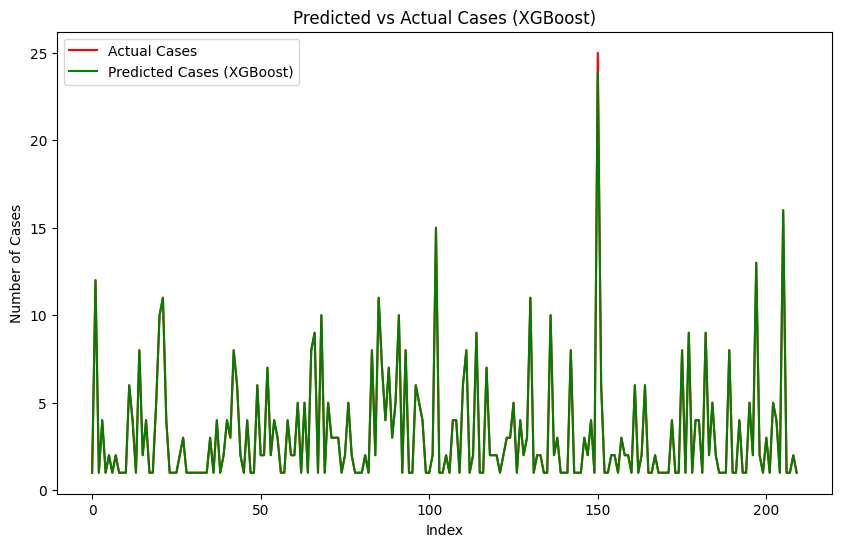

In [90]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# ✅ 4. กำหนด X และ y
X = df_final_clean_encoded.drop(columns=['เพศ','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ✅ 5. แบ่งชุด train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ✅ 6. สร้างโมเดล XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# ✅ 7. ฝึกโมเดล
xgb_model.fit(X_train, y_train)

# ✅ 8. ทำนายผล
y_pred = xgb_model.predict(X_test)

# ✅ 9. ประเมินผล
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)  # คำนวณ MAE

print(f"✅ XGBoost RMSE: {rmse:.2f}")
print(f"✅ XGBoost R²: {r2:.3f}")
print(f"✅ XGBoost MAE: {mae:.2f}")  # แสดงผล MAE

# ✅ 10. วาดกราฟเปรียบเทียบค่าทำนาย vs ค่าจริง
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual Cases', color='red')
plt.plot(y_pred, label='Predicted Cases (XGBoost)', color='green')
plt.title('Predicted vs Actual Cases (XGBoost)')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()


In [ ]:
import joblib
joblib.dump(xgb_model, "xgb_regressor.pkl")
print("✅ Saved new model: xgb_regressor.pkl")


✅ Saved new model: xgb_regressor.pkl


ทำใหม่เทรน


🔹 XGBoost RMSE: 3.12, R²: 0.167, MAE: 2.33
📊 XGBoost CV R² mean: -0.097, std: 0.211
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


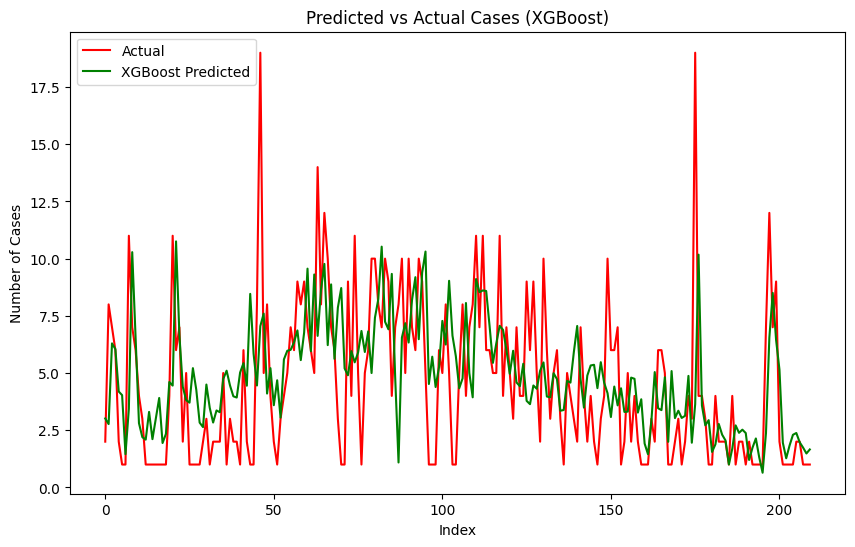

In [11]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# -------------------------------
# 1) เตรียมข้อมูล + lag features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X = df_with_lag.drop(columns=["cases", "เพศ", "อายุ(ปี)", "ไตรมาส", "humid_15d_avg"])
y = df_with_lag["cases"]

# -------------------------------
# 2) Train/Test Split (Time Series)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "MAE": mae}, y_pred

# -------------------------------
# 3) Train + Evaluate XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)

xgb_result, xgb_pred = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

# Cross-validation (TimeSeriesSplit)
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(xgb_model, X, y, cv=tscv, scoring="r2")
print(f"📊 XGBoost CV R² mean: {cv_scores.mean():.3f}, std: {cv_scores.std():.3f}")

# -------------------------------
# 4) Save XGBoost Model + Features
# -------------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(X.columns.tolist(), "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")

# -------------------------------
# 5) Visualization
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(xgb_pred, label="XGBoost Predicted", color="green")
plt.title("Predicted vs Actual Cases (XGBoost)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()


🔹 XGBoost RMSE: 3.12, R²: 0.167, MAE: 2.33
🔹 RandomForest RMSE: 2.97, R²: 0.245, MAE: 2.24
🔹 Deep Learning RMSE: 3.06, R²: 0.198, MAE: 2.32

📊 Performance Comparison:
           Model      RMSE        R2       MAE
0        XGBoost  3.116279  0.167044  2.330670
1   RandomForest  2.966994  0.244937  2.243819
2  Deep Learning  3.057424  0.198209  2.320110


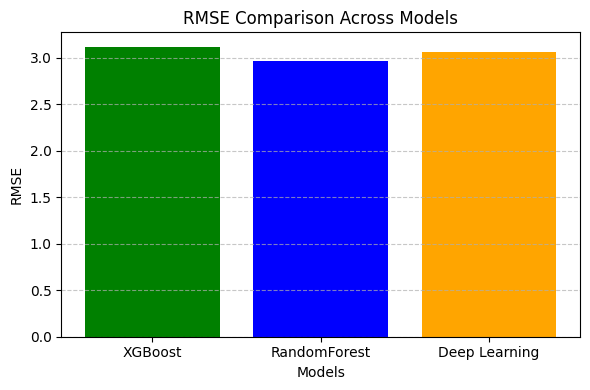

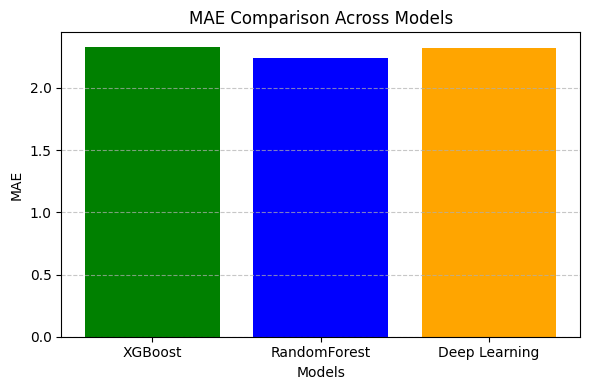

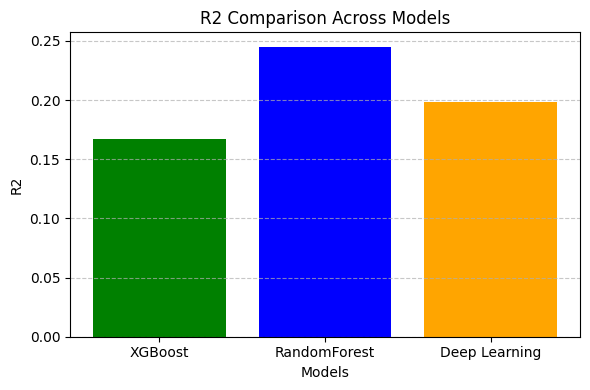

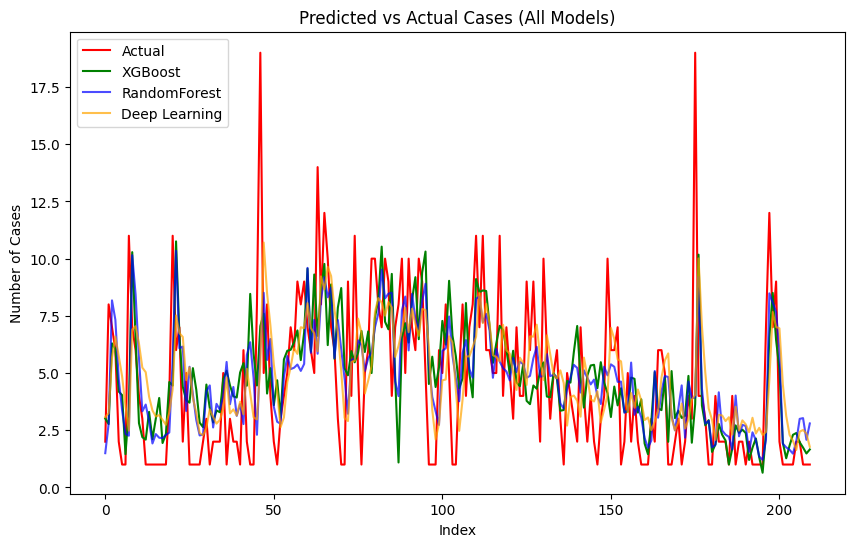

In [50]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) เตรียมข้อมูล + lag features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X = df_with_lag.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y = df_with_lag["cases"]

# -------------------------------
# 2) Train/Test Split (time series)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }, y_pred

# -------------------------------
# 3) Train + Evaluate Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)
xgb_result, xgb_pred = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)
rf_result, rf_pred = evaluate_model("RandomForest", rf_model, X_train, X_test, y_train, y_test)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)
mlp_result, mlp_pred = evaluate_model("Deep Learning", mlp_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 4) รวมผลลัพธ์เป็นตาราง
# -------------------------------
results_df = pd.DataFrame([xgb_result, rf_result, mlp_result])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 5) วาดกราฟเปรียบเทียบ (Metric)
# -------------------------------
metrics = ["RMSE", "MAE", "R2"]
for metric in metrics:
    plt.figure(figsize=(6,4))
    plt.bar(results_df["Model"], results_df[metric], color=["green","blue","orange"])
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6) วาดกราฟ Predicted vs Actual
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(xgb_pred, label="XGBoost", color="green")
plt.plot(rf_pred, label="RandomForest", color="blue", alpha=0.7)
plt.plot(mlp_pred, label="Deep Learning", color="orange", alpha=0.7)
plt.title("Predicted vs Actual Cases (All Models)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()


เทียบว่าถ้ามีเลกเเละไม่มี

🔹 XGBoost (No Lag) RMSE: 3.31, R²: 0.060, MAE: 2.40
🔹 XGBoost (Lag Features) RMSE: 3.12, R²: 0.167, MAE: 2.33

📊 Performance Comparison:
                    Model      RMSE        R2       MAE
0        XGBoost (No Lag)  3.311099  0.059641  2.395751
1  XGBoost (Lag Features)  3.116279  0.167044  2.330670


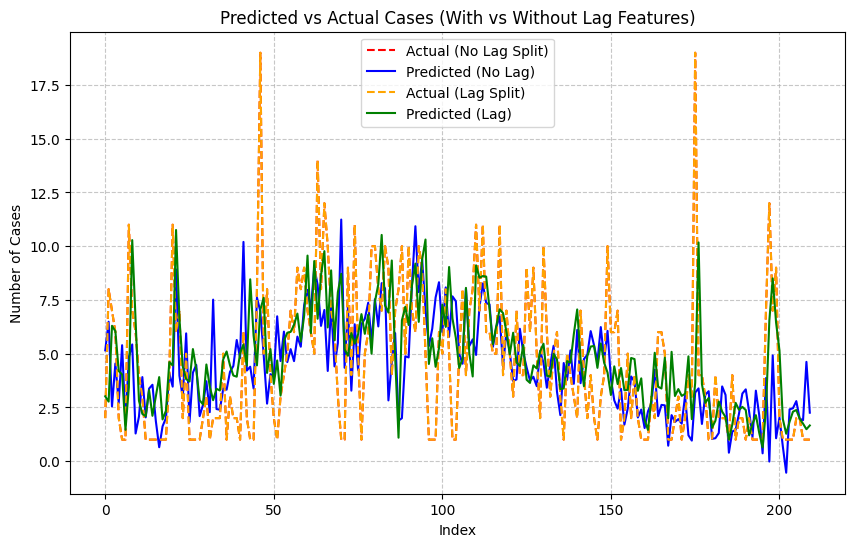

💾 Saved: xgb_regressor.pkl + xgb_features.pkl (Lag Version)


In [28]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }, y_pred

# -------------------------------
# 1) Dataset แบบไม่มี Lag Features
# -------------------------------
X_no_lag = df_final_clean_encoded.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y_no_lag = df_final_clean["cases"]

X_train_nl, X_test_nl, y_train_nl, y_test_nl = train_test_split(
    X_no_lag, y_no_lag, test_size=0.2, shuffle=False, random_state=42
)

xgb_no_lag = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)

res_no_lag, y_pred_nl = evaluate_model("XGBoost (No Lag)", xgb_no_lag,
                                       X_train_nl, X_test_nl, y_train_nl, y_test_nl)

# -------------------------------
# 2) Dataset แบบมี Lag Features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X_lag = df_with_lag.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y_lag = df_with_lag["cases"]

X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(
    X_lag, y_lag, test_size=0.2, shuffle=False, random_state=42
)

xgb_lag = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)

res_lag, y_pred_l = evaluate_model("XGBoost (Lag Features)", xgb_lag,
                                   X_train_l, X_test_l, y_train_l, y_test_l)

# -------------------------------
# 3) รวมผลลัพธ์เปรียบเทียบ
# -------------------------------
results_df = pd.DataFrame([res_no_lag, res_lag])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 4) วาดกราฟเปรียบเทียบ
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test_nl.values, label="Actual (No Lag Split)", color="red", linestyle="--")
plt.plot(y_pred_nl, label="Predicted (No Lag)", color="blue")
plt.plot(y_test_l.values, label="Actual (Lag Split)", color="orange", linestyle="--")
plt.plot(y_pred_l, label="Predicted (Lag)", color="green")
plt.title("Predicted vs Actual Cases (With vs Without Lag Features)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 5) บันทึกโมเดล Lag (เลือกไว้ใช้จริง)
# -------------------------------
joblib.dump(xgb_lag, "xgb_regressor.pkl")
joblib.dump(X_lag.columns.tolist(), "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl (Lag Version)")


In [18]:
X

,temp_15d_avg,rain_15d_avg,อาชีพ,ตำบล,อำเภอ,เดือน,ปี,ฤดูกาล,cases_lag1,cases_lag2,cases_lag3
0,27.970000,4.253333,10,60,8,5,2017,1,1.0,1.0,1.0
1,28.501333,4.233333,9,60,8,5,2017,1,1.0,1.0,1.0
2,28.355333,4.253333,9,60,8,5,2017,1,2.0,1.0,1.0
3,28.310000,2.100000,6,60,8,5,2017,1,1.0,2.0,1.0
4,27.778000,15.313333,10,29,5,5,2017,0,1.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
1042,22.858571,2.071429,6,3,2,12,2024,2,1.0,1.0,1.0
1043,22.716667,1.933333,7,31,2,12,2024,2,2.0,1.0,1.0
1044,21.687333,1.933333,10,15,2,12,2024,2,2.0,2.0,1.0
1045,21.304667,1.933333,7,35,6,12,2024,2,1.0,2.0,2.0


ลองทำแบบไม่มีเดือน


ทำแบบกรอก


In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import joblib

# -------------------------------
# 1) เตรียมข้อมูล
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df = df.dropna()

X = df[["temp_15d_avg","rain_15d_avg","อาชีพ","ตำบล","อำเภอ"]]  # ฟีเจอร์ที่ให้ user กรอก
y = df["cases"]

# One-hot หรือ Label Encoding (ถ้ามีตัวแปรหมวดหมู่)
X = pd.get_dummies(X, columns=["อาชีพ","ตำบล","อำเภอ"], drop_first=True)

# -------------------------------
# 2) Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# -------------------------------
# 3) Train XGBoost
# -------------------------------
model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)
model.fit(X_train, y_train)

# -------------------------------
# 4) Evaluate
# -------------------------------
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")

# -------------------------------
# 5) Save Model + Features
# -------------------------------
joblib.dump(model, "xgb_regressor_input.pkl")
joblib.dump(X.columns.tolist(), "xgb_features_input.pkl")
print("💾 Saved: xgb_regressor_input.pkl + xgb_features_input.pkl")


RMSE: 3.11, R²: 0.125, MAE: 2.12
💾 Saved: xgb_regressor_input.pkl + xgb_features_input.pkl


เทียบ

🔹 XGBoost RMSE: 3.31, R²: 0.060, MAE: 2.40
🔹 RandomForest RMSE: 3.29, R²: 0.069, MAE: 2.53
🔹 MLPRegressor RMSE: 3.36, R²: 0.032, MAE: 2.69

📊 Performance Comparison:
          Model      RMSE        R2       MAE
0       XGBoost  3.311099  0.059641  2.395751
1  RandomForest  3.294758  0.068899  2.530761
2  MLPRegressor  3.359025  0.032221  2.686103


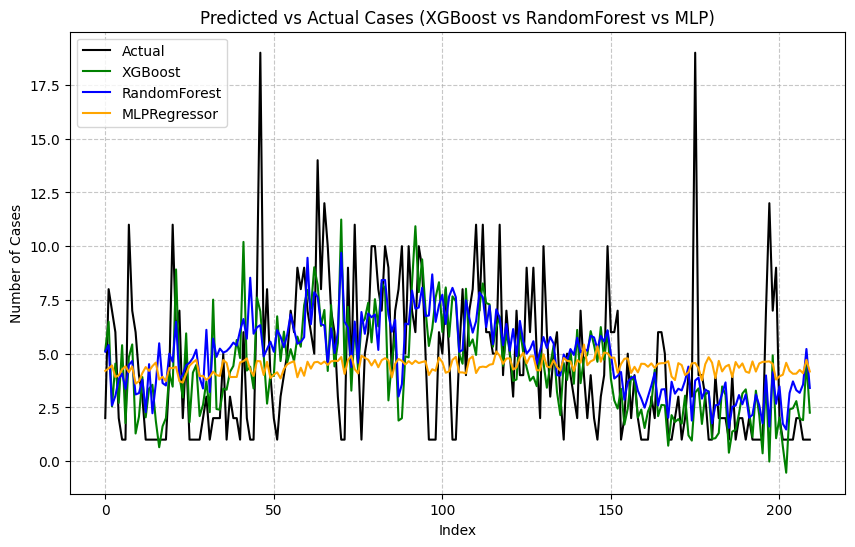

<Figure size 1000x600 with 0 Axes>

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3620 (\N{THAI CHARACTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3604 (\N{THAI CHARACTER DO DEK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3641 (\N{THAI CHARACTER SARA UU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\

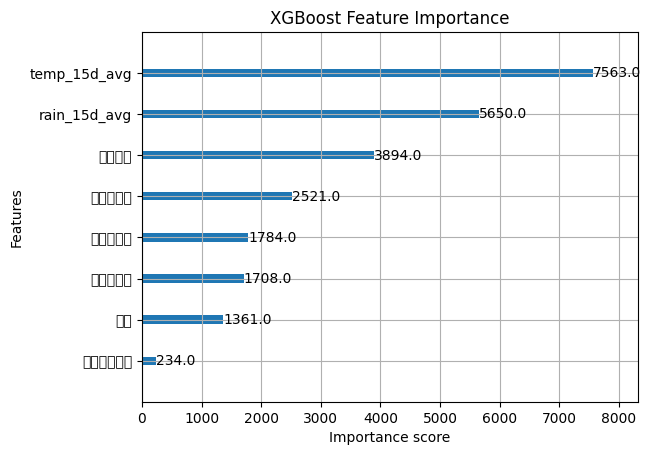

C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3635 (\N{THAI CHARACTER SARA AM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3616 (\N{THAI CHARACTER PHO SAMPHAO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3611 (\N{THAI CHARACTER PO PLA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_4468\3096811674.py:101: UserWarning: Glyph 3637 (\N{THAI CHARACTER SARA II}) missi

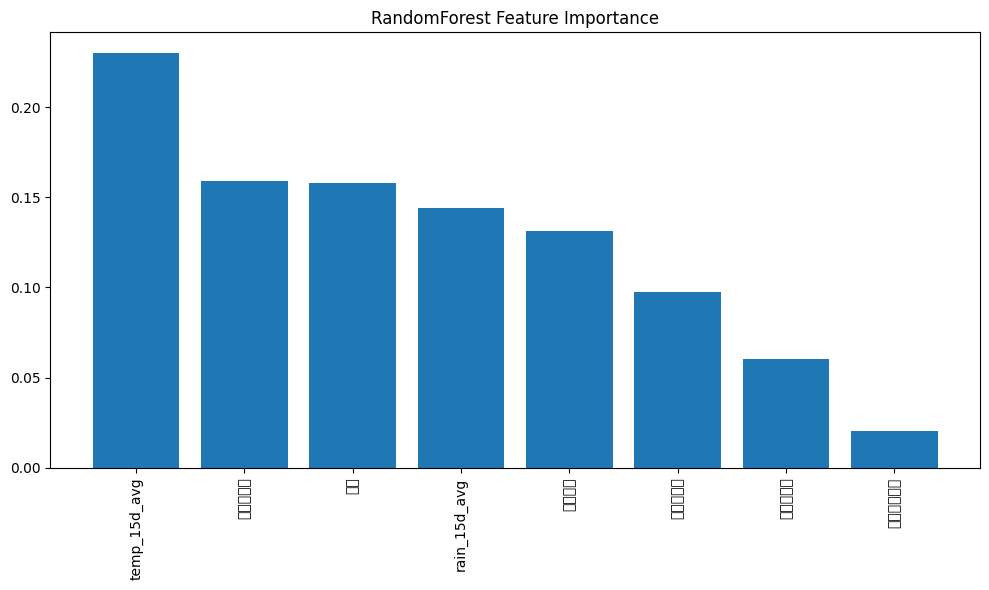

In [17]:
from xgboost import XGBRegressor, plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) เตรียมข้อมูล
# -------------------------------
X_no_lag = df_final_clean_encoded.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y_no_lag = df_final_clean["cases"]

# -------------------------------
# 2) Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_no_lag, y_no_lag, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "MAE": mae}, y_pred, model

# -------------------------------
# 3) XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)
xgb_result, xgb_pred, xgb_model = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 4) RandomForest
# -------------------------------
rf_model = RandomForestRegressor(
    n_estimators=500, max_depth=12, random_state=42
)
rf_result, rf_pred, rf_model = evaluate_model("RandomForest", rf_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 5) Deep Learning (MLP)
# -------------------------------
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32, 16),
    activation="relu", solver="adam",
    learning_rate_init=0.001, max_iter=1000,
    random_state=42
)
mlp_result, mlp_pred, _ = evaluate_model("MLPRegressor", mlp_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 6) รวมผลลัพธ์เปรียบเทียบ
# -------------------------------
results_df = pd.DataFrame([xgb_result, rf_result, mlp_result])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# Visualization: Predicted vs Actual
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black")
plt.plot(xgb_pred, label="XGBoost", color="green")
plt.plot(rf_pred, label="RandomForest", color="blue")
plt.plot(mlp_pred, label="MLPRegressor", color="orange")
plt.title("Predicted vs Actual Cases (XGBoost vs RandomForest vs MLP)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 7) Feature Importance
# -------------------------------
# XGBoost Feature Importance
plt.figure(figsize=(10,6))
plot_importance(xgb_model, importance_type="weight", title="XGBoost Feature Importance")
plt.show()

# RandomForest Feature Importance
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("RandomForest Feature Importance")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), X_no_lag.columns[indices], rotation=90)
plt.tight_layout()
plt.show()


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
LSTM → RMSE: 3.16, R²: 0.143, MAE: 2.20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
GRU → RMSE: 3.15, R²: 0.146, MAE: 2.26


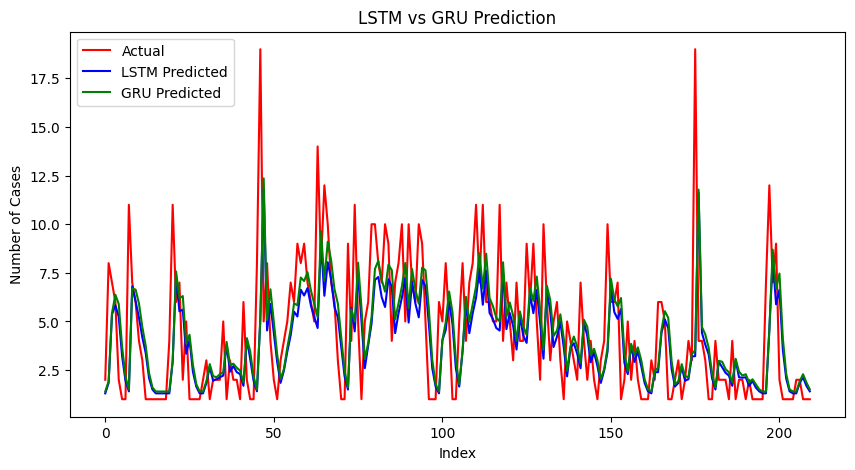

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# -------------------------------
# 1) เตรียมข้อมูล (Time Series)
# -------------------------------
df = df_final_clean.copy()   # ใช้ dataset ของคุณ
data = df["cases"].values.reshape(-1,1)

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# กำหนด sequence length (ใช้ข้อมูลย้อนหลัง n วัน/เดือน)
time_steps = 3  

X, y = [], []
for i in range(len(data_scaled) - time_steps):
    X.append(data_scaled[i:i+time_steps])
    y.append(data_scaled[i+time_steps])
X, y = np.array(X), np.array(y)

# Train/Test Split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# -------------------------------
# 2) สร้าง Model LSTM
# -------------------------------
model_lstm = Sequential([
    LSTM(64, activation='tanh', input_shape=(time_steps,1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# -------------------------------
# 3) สร้าง Model GRU
# -------------------------------
model_gru = Sequential([
    GRU(64, activation='tanh', input_shape=(time_steps,1)),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')

# -------------------------------
# 4) Train
# -------------------------------
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# -------------------------------
# 5) Evaluate
# -------------------------------
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    y_pred_inv = scaler.inverse_transform(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    r2 = r2_score(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return y_test_inv, y_pred_inv

y_true_lstm, y_pred_lstm = evaluate_model("LSTM", model_lstm, X_test, y_test)
y_true_gru, y_pred_gru = evaluate_model("GRU", model_gru, X_test, y_test)

# -------------------------------
# 6) Visualization
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(y_true_lstm, label="Actual", color="red")
plt.plot(y_pred_lstm, label="LSTM Predicted", color="blue")
plt.plot(y_pred_gru, label="GRU Predicted", color="green")
plt.title("LSTM vs GRU Prediction")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.show()


In [21]:
 pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.11.3-py3-none-any.whl.metadata (5.9 kB)
  Using cached markdown-3.9-py3-none-any.whl.metadata (5.1 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached wheel-0.45.1-py3-none-a

อันเก่า

📊 Comparison of Models (RMSE & MAE):
               Model  RMSE   MAE
0  Gradient Boosting  0.39  0.03
1            XGBoost  0.08  0.01
2      Random Forest  0.39  0.03
3      Deep Learning  0.13  0.10


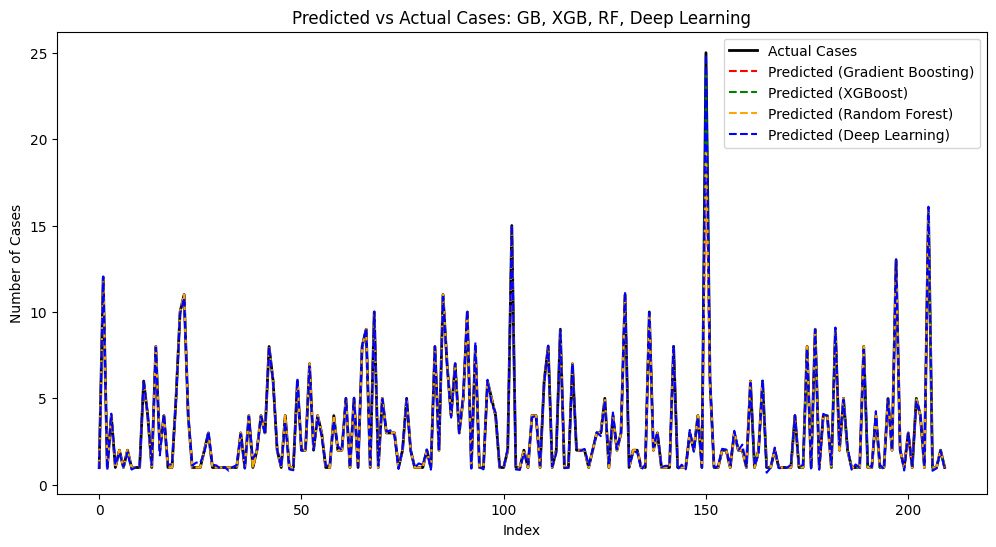

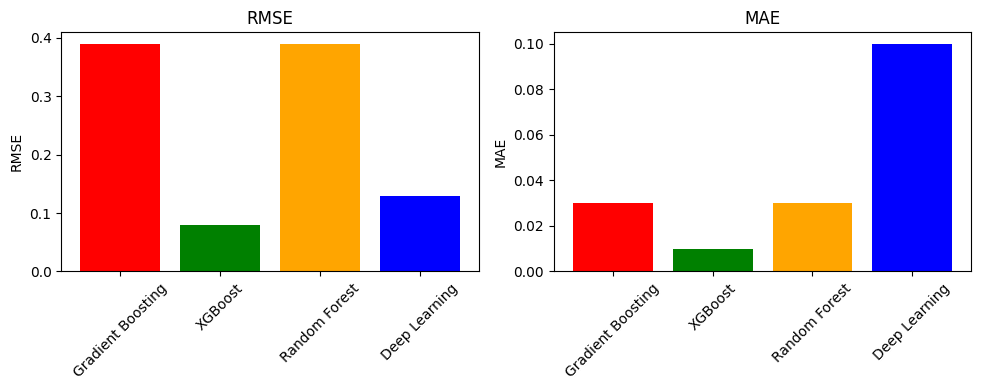

In [ ]:
# ==========================
# 0. Import Libraries
# ==========================
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ==========================
# 1. กำหนด X และ y
# ==========================
X = df_final_clean_encoded.drop(columns=['เพศ','เดือน','อายุ(ปี)','ไตรมาส','humid_15d_avg'])
y = df_final_clean['cases']

# ==========================
# 2. แบ่งชุด train/test
# ==========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ==========================
# 3. Standardize สำหรับ Deep Learning
# ==========================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================
# 4. โมเดล Gradient Boosting
# ==========================
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

# ==========================
# 5. โมเดล XGBoost
# ==========================
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# ==========================
# 6. โมเดล Random Forest
# ==========================
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ==========================
# 7. โมเดล Deep Learning (MLP)
# ==========================
dl_model = MLPRegressor(hidden_layer_sizes=(64,32), activation='relu', solver='adam',
                        max_iter=500, random_state=42)
dl_model.fit(X_train_scaled, y_train)
y_pred_dl = dl_model.predict(X_test_scaled)

# ==========================
# 8. ประเมินผล RMSE & MAE
# ==========================
models = ['Gradient Boosting', 'XGBoost', 'Random Forest', 'Deep Learning']
preds = [y_pred_gb, y_pred_xgb, y_pred_rf, y_pred_dl]

metrics = []
for name, y_pred in zip(models, preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    metrics.append({'Model': name, 'RMSE': round(rmse,2), 'MAE': round(mae,2)})

metrics_df = pd.DataFrame(metrics)
print("📊 Comparison of Models (RMSE & MAE):")
print(metrics_df)

# ==========================
# 9. กราฟ Actual vs Predicted
# ==========================
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Cases', color='black', linewidth=2)
plt.plot(y_pred_gb, label='Predicted (Gradient Boosting)', color='red', linestyle='--')
plt.plot(y_pred_xgb, label='Predicted (XGBoost)', color='green', linestyle='--')
plt.plot(y_pred_rf, label='Predicted (Random Forest)', color='orange', linestyle='--')
plt.plot(y_pred_dl, label='Predicted (Deep Learning)', color='blue', linestyle='--')
plt.title('Predicted vs Actual Cases: GB, XGB, RF, Deep Learning')
plt.xlabel('Index')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# ==========================
# 10. Bar chart RMSE & MAE
# ==========================
plt.figure(figsize=(10,4))
metrics_list = ['RMSE','MAE']
colors = ['red','green','orange','blue']

for i, metric in enumerate(metrics_list):
    plt.subplot(1,2,i+1)
    plt.bar(metrics_df['Model'], metrics_df[metric], color=colors)
    plt.title(metric)
    plt.ylabel(metric)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🔹 XGBoost → RMSE: 3.13, R²: 0.159, MAE: 2.30
🔹 RandomForest → RMSE: 3.05, R²: 0.202, MAE: 2.27


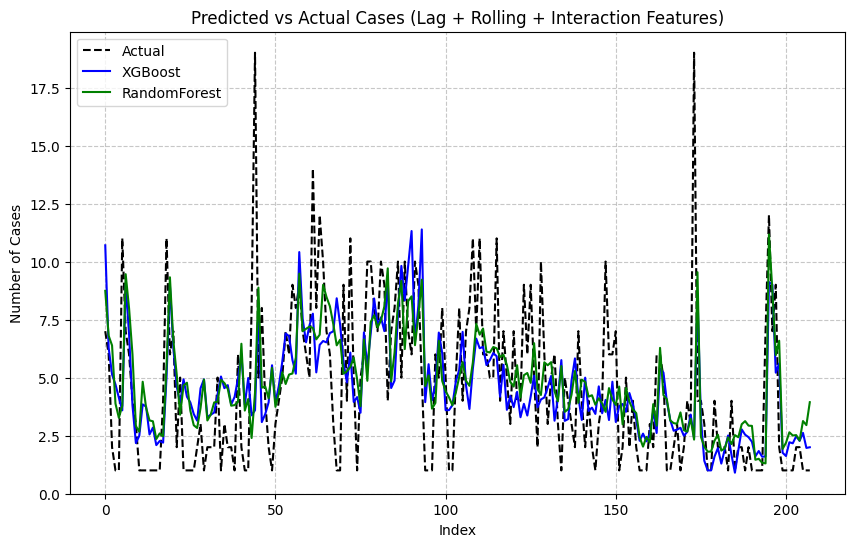

📊 XGBoost CV R²: -0.075 (+/- 0.274)
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [41]:
# -------------------------------
# 📦 Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# -------------------------------
# 📂 Load data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# ⏳ Feature Engineering
# -------------------------------
# lag features (ย้อนหลัง 1–12 เดือน)
for lag in range(1, 13):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

# rolling mean ของเคสย้อนหลัง 3,6,12 เดือน
df["cases_roll3"] = df["cases"].shift(1).rolling(3).mean()
df["cases_roll6"] = df["cases"].shift(1).rolling(6).mean()
df["cases_roll12"] = df["cases"].shift(1).rolling(12).mean()

# seasonality features
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# interaction feature
df["temp_rain_interact"] = df["temp_15d_avg"] * df["rain_15d_avg"]

# ลบ NA หลังสร้าง lag/rolling
df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 Features & Target
# -------------------------------
selected_features = [
    "temp_15d_avg", "rain_15d_avg", "humid_15d_avg",
    "cases_lag1","cases_lag2","cases_lag3","cases_lag6","cases_lag12",
    "cases_roll3","cases_roll6","cases_roll12",
    "month_sin","month_cos","year",
    "temp_rain_interact"
]

X = df[selected_features]
y = df["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# -------------------------------
# 📊 Evaluate Function
# -------------------------------
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return y_pred, model

# -------------------------------
# 🚀 Train Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=1500, learning_rate=0.01, max_depth=6,
    subsample=0.7, colsample_bytree=0.8,
    reg_lambda=2, reg_alpha=1,
    random_state=42, objective="reg:squarederror"
)
rf_model = RandomForestRegressor(
    n_estimators=1000, max_depth=15, random_state=42
)

y_pred_xgb, xgb_fitted = evaluate_model("XGBoost", xgb_model)
y_pred_rf, rf_fitted = evaluate_model("RandomForest", rf_model)

# -------------------------------
# 📈 Plot results
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black", linestyle="--")
plt.plot(y_pred_xgb, label="XGBoost", color="blue")
plt.plot(y_pred_rf, label="RandomForest", color="green")
plt.title("Predicted vs Actual Cases (Lag + Rolling + Interaction Features)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 🔍 Cross Validation (XGBoost)
# -------------------------------
tscv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(
    xgb_model, X, y, cv=tscv, scoring="r2"
)
print(f"📊 XGBoost CV R²: {cv_scores.mean():.3f} (+/- {cv_scores.std():.3f})")

# -------------------------------
# 💾 Save Best Model (XGB)
# -------------------------------
joblib.dump(xgb_fitted, "xgb_regressor.pkl")
joblib.dump(selected_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


🔹 XGBoost → RMSE: 3.19, R²: 0.126, MAE: 2.39
🔹 RandomForest → RMSE: 3.16, R²: 0.143, MAE: 2.38
🔹 MLPRegressor → RMSE: 3.04, R²: 0.210, MAE: 2.24


c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
🔹 LSTM → RMSE: 3.03, R²: 0.211, MAE: 2.29

📊 Performance Comparison:
          Model      RMSE        R2       MAE
0       XGBoost  3.192104  0.126015  2.386749
1  RandomForest  3.161647  0.142614  2.384627
2  MLPRegressor  3.035190  0.209829  2.240281
3          LSTM  3.032895  0.211023  2.286509


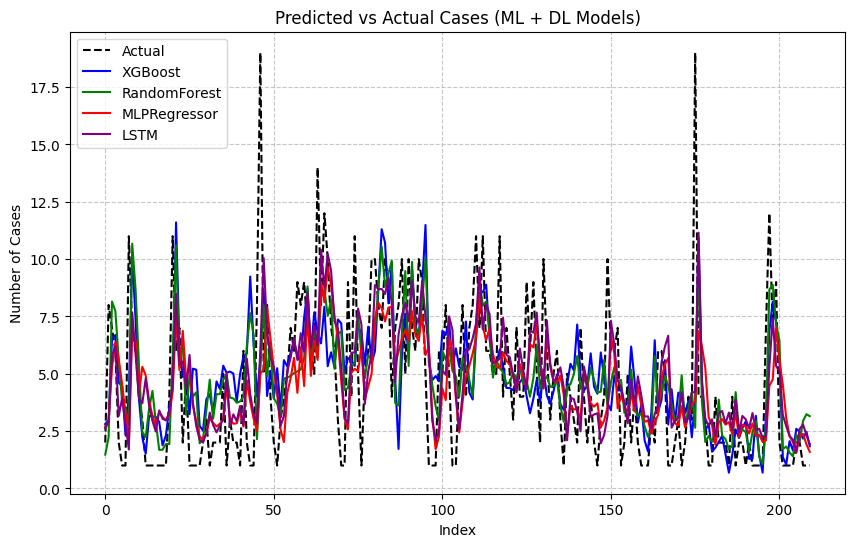

💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [53]:
# train_model.py
# -------------------------------
# 📦 Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# -------------------------------
# 📂 Load Data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# 🔄 Encode Categorical
# -------------------------------
categorical_cols = ["อาชีพ", "ตำบล", "อำเภอ", "ฤดูกาล"]
for col in categorical_cols:
    if col in df.columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))

# -------------------------------
# ⏳ Feature Engineering
# -------------------------------
# lag features (ย้อนหลัง 1–3 เดือน)
for lag in range(1, 4):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

# rolling mean ของเคสย้อนหลัง 3 เดือน
df["cases_roll3"] = df["cases"].shift(1).rolling(3).mean()

# seasonality features
df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
df["month_cos"] = np.cos(2*np.pi*df["month"]/12)

# drop NA
df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 Features & Target
# -------------------------------
selected_features = [
    "ปี",
    "temp_15d_avg", "rain_15d_avg",
    "อาชีพ", "ตำบล", "อำเภอ", "ฤดูกาล",
    "cases_lag1","cases_lag2","cases_lag3",
    "cases_roll3",
    "month_sin","month_cos"
]

X = df[selected_features]
y = df["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# 📊 Evaluate Function
# -------------------------------
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {"Model": name, "RMSE": rmse, "R2": r2, "MAE": mae}, y_pred, model

# -------------------------------
# 🚀 Train ML Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=1000, learning_rate=0.03, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, reg_lambda=1,
    random_state=42, objective="reg:squarederror"
)
rf_model = RandomForestRegressor(
    n_estimators=1000, max_depth=12, random_state=42
)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32), activation="relu",
    solver="adam", max_iter=500, random_state=42
)

res_xgb, y_pred_xgb, xgb_fitted = evaluate_model("XGBoost", xgb_model)
res_rf, y_pred_rf, rf_fitted = evaluate_model("RandomForest", rf_model)
res_mlp, y_pred_mlp, mlp_fitted = evaluate_model("MLPRegressor", mlp_model)

# -------------------------------
# 🤖 LSTM (Deep Learning)
# -------------------------------
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# reshape → [samples, timesteps, features]
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))
X_train_lstm, X_test_lstm = train_test_split(
    X_lstm, test_size=0.2, shuffle=False, random_state=42
)
y_train_lstm, y_test_lstm = train_test_split(
    y, test_size=0.2, shuffle=False, random_state=42
)

model_lstm = Sequential()
model_lstm.add(LSTM(64, activation='relu', input_shape=(X_lstm.shape[1], X_lstm.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=16, verbose=0)

y_pred_lstm = model_lstm.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))
r2_lstm = r2_score(y_test_lstm, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test_lstm, y_pred_lstm)
print(f"🔹 LSTM → RMSE: {rmse_lstm:.2f}, R²: {r2_lstm:.3f}, MAE: {mae_lstm:.2f}")

# -------------------------------
# 📊 Compare All
# -------------------------------
results_df = pd.DataFrame([
    res_xgb,
    res_rf,
    res_mlp,
    {"Model": "LSTM", "RMSE": rmse_lstm, "R2": r2_lstm, "MAE": mae_lstm}
])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 📈 Plot Results
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="black", linestyle="--")
plt.plot(y_pred_xgb, label="XGBoost", color="blue")
plt.plot(y_pred_rf, label="RandomForest", color="green")
plt.plot(y_pred_mlp, label="MLPRegressor", color="red")
plt.plot(y_pred_lstm, label="LSTM", color="purple")
plt.title("Predicted vs Actual Cases (ML + DL Models)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

# -------------------------------
# 💾 Save Best Model (XGB + Features)
# -------------------------------
joblib.dump(xgb_fitted, "xgb_regressor.pkl")
joblib.dump(selected_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


In [57]:
# train_model.py
# -------------------------------
# 📦 Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# -------------------------------
# 📂 Load Data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# ⏳ Feature Engineering (lag 1–3)
# -------------------------------
for lag in range(1, 4):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 Features & Target
# -------------------------------
selected_features = [
    "temp_15d_avg", "rain_15d_avg",
    "cases_lag1", "cases_lag2", "cases_lag3"
]

X = df[selected_features]
y = df["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# 🚀 Train XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=800, learning_rate=0.05, max_depth=6,
    subsample=0.8, colsample_bytree=0.8, random_state=42,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# -------------------------------
# 📊 Evaluate
# -------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🔹 XGBoost → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")

# -------------------------------
# 💾 Save model + features
# -------------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(selected_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


🔹 XGBoost → RMSE: 3.40, R²: 0.011, MAE: 2.47
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [64]:
# train_model.py
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor

# -------------------------------
# 📂 Load Data
# -------------------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# -------------------------------
# ⏳ Feature Engineering (lag 1–3)
# -------------------------------
for lag in range(1, 4):
    df[f"cases_lag{lag}"] = df["cases"].shift(lag)

df = df.dropna().reset_index(drop=True)

# -------------------------------
# 🎯 เลือกฟีเจอร์ตาม correlation
# -------------------------------
corr = df.corr(numeric_only=True)["cases"].abs().sort_values(ascending=False)
print("📊 Correlation with cases:\n", corr)

# เลือก top 7 ฟีเจอร์ (ยกเว้น target เอง)
top_features = corr.drop("cases").head(7).index.tolist()
print("✅ Selected features:", top_features)

# -------------------------------
# 🔡 Encoding categorical
# -------------------------------
df_encoded = df.copy()
cat_features = [col for col in top_features if df_encoded[col].dtype == "object"]

for col in cat_features:
    df_encoded[col] = df_encoded[col].astype("category").cat.codes

X = df_encoded[top_features]
y = df_encoded["cases"]

# -------------------------------
# 🔀 Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# 🚀 Train XGBoost
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    objective="reg:squarederror"
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

# -------------------------------
# 📊 Evaluate
# -------------------------------
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"🔹 XGBoost → RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")

# -------------------------------
# 💾 Save model + features
# -------------------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(top_features, "xgb_features.pkl")
print("💾 Saved: xgb_regressor.pkl + xgb_features.pkl")


📊 Correlation with cases:
 cases            1.000000
cases_lag1       0.573559
cases_lag2       0.423437
cases_lag3       0.308246
ปี               0.226934
year             0.226934
temp_15d_avg     0.099039
rain_15d_avg     0.093032
อายุ(ปี)         0.034282
humid_15d_avg    0.017900
ไตรมาส           0.011275
เดือน            0.008118
month            0.008118
Name: cases, dtype: float64
✅ Selected features: ['cases_lag1', 'cases_lag2', 'cases_lag3', 'ปี', 'year', 'temp_15d_avg', 'rain_15d_avg']
🔹 XGBoost → RMSE: 3.24, R²: 0.102, MAE: 2.41
💾 Saved: xgb_regressor.pkl + xgb_features.pkl


In [73]:
pip install jinja2


🔹 XGBoost RMSE: 3.12, R²: 0.167, MAE: 2.33
🔹 RandomForest RMSE: 2.97, R²: 0.245, MAE: 2.24
🔹 Deep Learning RMSE: 3.06, R²: 0.198, MAE: 2.32

📊 Performance Comparison:
           Model      RMSE        R2       MAE
0        XGBoost  3.116279  0.167044  2.330670
1   RandomForest  2.966994  0.244937  2.243819
2  Deep Learning  3.057424  0.198209  2.320110


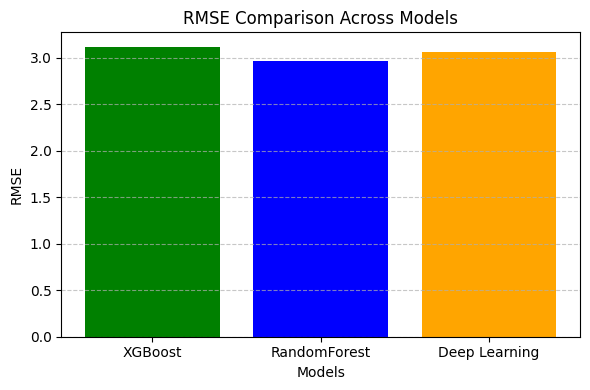

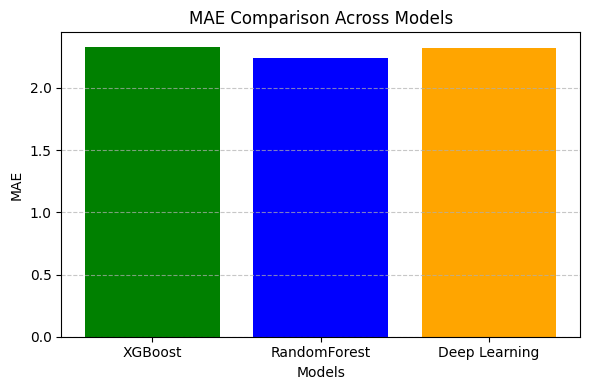

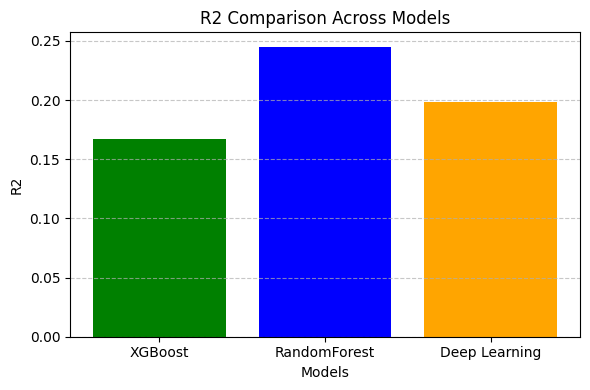

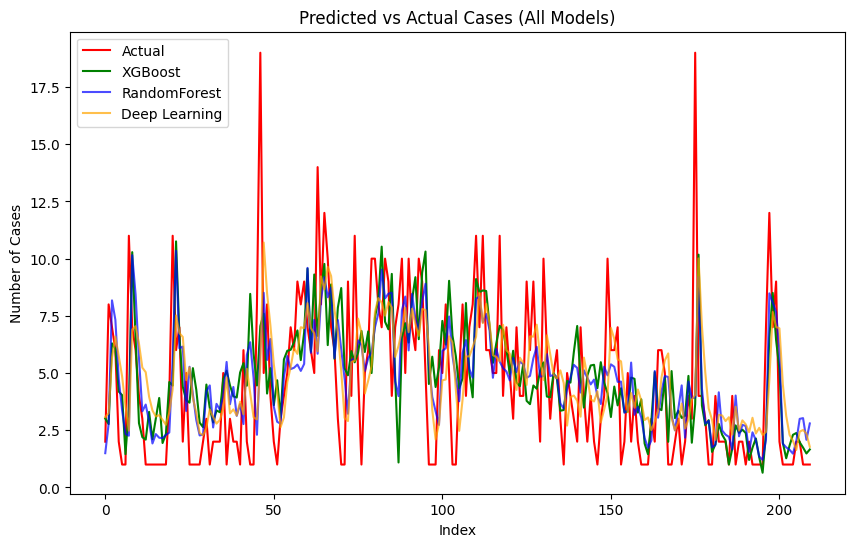

In [76]:

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1) เตรียมข้อมูล + lag features
# -------------------------------
df_with_lag = df_final_clean_encoded.copy()
df_with_lag["cases_lag1"] = df_final_clean["cases"].shift(1)
df_with_lag["cases_lag2"] = df_final_clean["cases"].shift(2)
df_with_lag["cases_lag3"] = df_final_clean["cases"].shift(3)
df_with_lag = df_with_lag.dropna().reset_index(drop=True)

X = df_with_lag.drop(columns=["cases","เพศ","อายุ(ปี)","ไตรมาส","humid_15d_avg"])
y = df_with_lag["cases"]

# -------------------------------
# 2) Train/Test Split (time series)
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False, random_state=42
)

# -------------------------------
# ฟังก์ชันประเมินผล
# -------------------------------
def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"🔹 {name} RMSE: {rmse:.2f}, R²: {r2:.3f}, MAE: {mae:.2f}")
    return {
        "Model": name,
        "RMSE": rmse,
        "R2": r2,
        "MAE": mae
    }, y_pred

# -------------------------------
# 3) Train + Evaluate Models
# -------------------------------
xgb_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    random_state=42
)
xgb_result, xgb_pred = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train, y_test)

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42
)
rf_result, rf_pred = evaluate_model("RandomForest", rf_model, X_train, X_test, y_train, y_test)

mlp_model = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    max_iter=500,
    random_state=42
)
mlp_result, mlp_pred = evaluate_model("Deep Learning", mlp_model, X_train, X_test, y_train, y_test)

# -------------------------------
# 4) รวมผลลัพธ์เป็นตาราง
# -------------------------------
results_df = pd.DataFrame([xgb_result, rf_result, mlp_result])
print("\n📊 Performance Comparison:")
print(results_df)

# -------------------------------
# 5) วาดกราฟเปรียบเทียบ (Metric)
# -------------------------------
metrics = ["RMSE", "MAE", "R2"]
for metric in metrics:
    plt.figure(figsize=(6,4))
    plt.bar(results_df["Model"], results_df[metric], color=["green","blue","orange"])
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xlabel("Models")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6) วาดกราฟ Predicted vs Actual
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(xgb_pred, label="XGBoost", color="green")
plt.plot(rf_pred, label="RandomForest", color="blue", alpha=0.7)
plt.plot(mlp_pred, label="Deep Learning", color="orange", alpha=0.7)
plt.title("Predicted vs Actual Cases (All Models)")
plt.xlabel("Index")
plt.ylabel("Number of Cases")
plt.legend()

In [82]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np

# -------------------
# Load Data
# -------------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ------------------- Generate Lag Features -------------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ------------------- Features -------------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ------------------- One-hot encode categorical -------------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ------------------- Train/Test split -------------------
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# ------------------- Train XGBoost -------------------
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)

# ------------------- Evaluate -------------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# ------------------- Save model + features + encoder -------------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("✅ Model trained & saved with categorical encoding + lag features")


📊 Model Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393
✅ Model trained & saved with categorical encoding + lag features


In [83]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib
import numpy as np

# ---------------- Load Data ----------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ---------------- Generate Lag Features ----------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ---------------- Features ----------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ---------------- One-hot Encode ----------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# ---------------- Train XGBoost ----------------
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)

# ---------------- Evaluate ----------------
y_pred = xgb_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("📊 Model Performance:")
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

# ---------------- Save Model ----------------
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("✅ Model trained & saved with categorical encoding + lag features")


📊 Model Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393
✅ Model trained & saved with categorical encoding + lag features


In [84]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import joblib
import numpy as np

# ---------------- Load Data ----------------
df = pd.read_excel("df_final_clean.xlsx")
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

# ---------------- Generate Lag Features ----------------
df = df.sort_values("date").reset_index(drop=True)
for k in [1, 2, 3]:
    df[f"cases_lag{k}"] = df["cases"].shift(k)

df = df.dropna().reset_index(drop=True)

# ---------------- Features ----------------
features = [
    "temp_15d_avg", "rain_15d_avg",
    "year", "month",
    "cases_lag1", "cases_lag2", "cases_lag3",
    "ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"
]

X = df[features]
y = df["cases"]

# ---------------- One-hot Encode ----------------
cat_cols = ["ตำบล", "อำเภอ", "อาชีพ", "ฤดูกาล"]
enc = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_cat = enc.fit_transform(X[cat_cols])
X_cat_df = pd.DataFrame(X_cat, columns=enc.get_feature_names_out(cat_cols))

X_num = X.drop(columns=cat_cols).reset_index(drop=True)
X_final = pd.concat([X_num, X_cat_df], axis=1)

# ---------------- Train/Test Split ----------------
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42
)

# ======================= Train Models =======================
# 1. XGBoost
xgb_model = XGBRegressor(
    n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# 2. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300, max_depth=10, random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 3. Deep Learning (MLPRegressor)
mlp_model = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32), activation="relu",
    solver="adam", max_iter=500, random_state=42
)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)

# ======================= Evaluate =======================
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {name} Performance:")
    print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")
    return rmse, mae, r2

eval_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb)
eval_rf = evaluate_model("Random Forest", y_test, y_pred_rf)
eval_mlp = evaluate_model("Deep Learning (MLP)", y_test, y_pred_mlp)

# ======================= Save Models =======================
joblib.dump(xgb_model, "xgb_regressor.pkl")
joblib.dump(rf_model, "rf_regressor.pkl")
joblib.dump(mlp_model, "mlp_regressor.pkl")
joblib.dump(list(X_final.columns), "xgb_features.pkl")
joblib.dump(enc, "xgb_encoder.pkl")

print("\n✅ All models trained & saved successfully!")



📊 XGBoost Performance:
RMSE: 2.54, MAE: 1.70, R²: 0.393

📊 Random Forest Performance:
RMSE: 2.52, MAE: 1.70, R²: 0.402

📊 Deep Learning (MLP) Performance:
RMSE: 2.70, MAE: 1.67, R²: 0.313

✅ All models trained & saved successfully!


In [80]:
import joblib
expected_features = joblib.load("xgb_features.pkl")
print(expected_features)


['temp_15d_avg', 'rain_15d_avg', 'อาชีพ', 'ตำบล', 'อำเภอ', 'เดือน', 'ปี', 'ฤดูกาล', 'cases_lag1', 'cases_lag2', 'cases_lag3']
